# Figure 13

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Scientific and datavis stack
import iris.cube
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

In [3]:
# My packages and local scripts
from aeolus.calc import time_mean
from aeolus.const import init_const
from aeolus.coord import isel
from aeolus.core import AtmoSim
from aeolus.io import load_data, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.region import Region
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    read_normalized_stellar_flux,
    read_spectral_bands,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    figsave,
    use_style,
)

In [4]:
import mypaths
from commons import GLM_MODEL_TIMESTEP, GLM_SUITE_ID, NIGHTSIDE, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

In [6]:
sim_label_a, sim_label_b = SIM_LABELS.keys()

Define paths to input data and results.

In [7]:
# SELECTED_SIM = {k: v for k, v in {**SIM}.items() if k in ["hab1", "hab2"]}
img_prefix = f"{GLM_SUITE_ID}_synthobs"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_synthobs"
time_prof = "synthobs"
plotdir = mypaths.plotdir / img_prefix

Define various options for spectral files (only one is actually used).

In [8]:
RAD_OPT_LABELS = {
    "dsa_mcica_hybrid": {
        "title": "DSA hybrid; MCICA",
        "kw_plt": {"color": "C1"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa_hybrid"
        / "sp_sw_280_dsa_trappist1",
    },
    "dsa_scaled_cloud_lowres": {
        "title": "DSA low-res; scaling factor",
        "kw_plt": {"color": "C2"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa"
        / "sp_sw_21_dsa_trappist1",
    },
    "dsa_scaled_cloud_highres": {
        "title": "DSA high-res; scaling factor",
        "kw_plt": {"color": "C3"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa_hr"
        / "sp_sw_280_dsa_trappist1",
    },
}

In [9]:
rad_opt_label = "dsa_mcica_hybrid"

Load processed data

In [10]:
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=sim_prop["planet"],
        const_dir=mypaths.constdir,
        model=um,
        vert_coord=None,
    )
    runs[sim_label].theta_levels = iris.cube.Cube(
        data=load_vert_lev(mypaths.home / "vert" / "vertlevs_L38_29t_9s_80km"),
        units="m",
        long_name="level_height",
    )
    runs[sim_label].spectral_file_sw = RAD_OPT_LABELS[rad_opt_label]["spectral_file_sw"]

## Process variables before plotting

Define rules for the variables to plot.

In [11]:
DIAGS = {
    "cloudy": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i555"),
        "title": "Cloudy",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:pink"},
    },
    "clear": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i556"),
        "title": "Clear-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:cyan"},
    },
    "dry": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i756"),
        "title": "Dry",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"color": "tab:olive"},
    },
}

Define how to subset data for the eastern or western terminators.

In [12]:
TERMINATORS = {
    "west_term": {
        "constraint": Region(180, 360, -90, 90).constraint,
        "title": "Western (morning) terminator",
        "label": "west_term",
        "kw_plt": dict(linestyle="-"),
    },
    "east_term": {
        "constraint": Region(0, 180, -90, 90).constraint,
        "title": "Eastern (evening) terminator",
        "label": "east_term",
        "kw_plt": dict(linestyle="--"),
    },
}

Store final results in a dictionary.

In [13]:
TERM_DIFF = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
    stellar_constant_at_1_au = (
        the_run.const.solar_constant
        * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
    )
    TERM_DIFF[sim_label] = {}
    for (vrbl_key, vrbl_prop) in DIAGS.items():
        TERM_DIFF[sim_label][vrbl_key] = {}
        cube = vrbl_prop["cube"](the_run)
        cube.units = tex2cf_units(vrbl_prop["tex_units"])
        cube_west = (
            calc_transmission_spectrum(
                cube.extract(TERMINATORS["west_term"]["constraint"]),
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )
        cube_east = (
            calc_transmission_spectrum(
                cube.extract(TERMINATORS["east_term"]["constraint"]),
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )
        TERM_DIFF[sim_label][vrbl_key] = cube_east - cube_west

## Create the figure

In [14]:
imgname = f"{img_prefix}__east_minus_west__{'_'.join(SIM_LABELS.keys())}__{'_'.join(DIAGS.keys())}"
kw_plt_common = {"lw": 1.0}

fig = plt.figure(figsize=(20, 5))

axd = fig.subplot_mosaic([[*SIM_LABELS.keys()]], gridspec_kw={"wspace": 0.1})

iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    ax.axhline(0, **KW_ZERO_LINE)
    xticks = np.concatenate([[0.6, 1, 1.4], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for sim_label in SIM_LABELS.keys():
    ax = axd[sim_label]
    ax.set_title(
        SIM_LABELS[sim_label]["title"],
        loc="right",
        size="medium",
    )

    for vrbl_key, vrbl_prop in DIAGS.items():
        cube_mean = time_mean(TERM_DIFF[sim_label][vrbl_key])
        cube_std = (TERM_DIFF[sim_label][vrbl_key]).collapsed(
            um.t, iris.analysis.STD_DEV
        )
        x = cube_mean.coord("spectral_band_centres")
        ax.fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            linewidth=0,
            **vrbl_prop["kw_plt"],
        )
        ax.plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **vrbl_prop["kw_plt"],
        )

add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in DIAGS.values()},
    },
    loc="upper center",
    frameon=False,
    ncol=len(DIAGS),
    fontsize="medium",
    title="Differences between eastern and western terminators",
    bbox_to_anchor=(0.5, 1.05),
)

plt.close()

# Show the figure

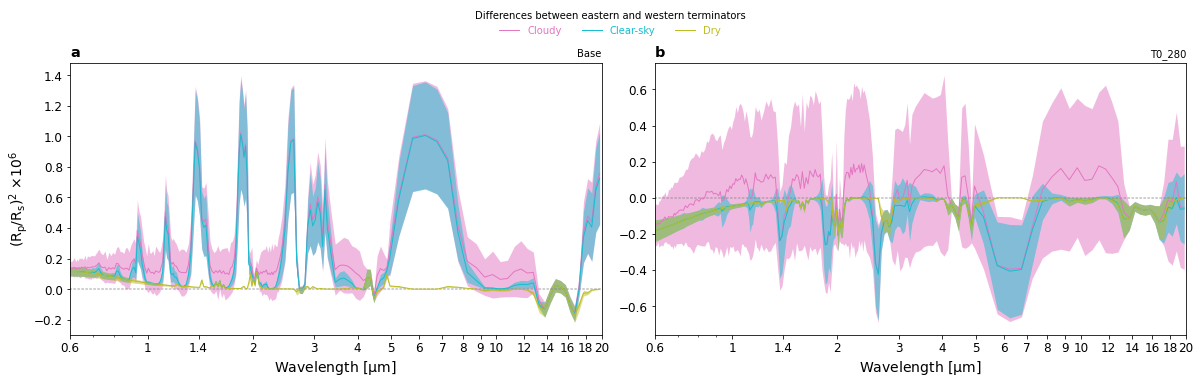

In [15]:
fig

* **Differences in the transmission depth (ppm) between terminators (eastern minus western) in the (a) SJ and (b) DJ cases.**
* **Different lines show spectral differences assuming (pink) cloudy, (cyan) clear-sky, and (olive) dry atmosphere.**

In [16]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_synthobs/ch111_synthobs__east_minus_west__base_sens-t280k__cloudy_clear_dry.png


---

## Extra

#### Terminator by terminator

In [17]:
sim_label_a, sim_label_b = SIM_LABELS.keys()
TERM_DIFF = {}
the_run_a = runs[sim_label_a]
planet_top_of_atmosphere = the_run_a.const.radius + the_run_a.theta_levels[-1]
stellar_constant_at_1_au = (
    the_run_a.const.solar_constant
    * (the_run_a.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
)
the_run_b = runs[sim_label_b]

for (vrbl_key, vrbl_prop) in DIAGS.items():
    TERM_DIFF[vrbl_key] = {}
    cube_a = vrbl_prop["cube"](the_run_a)
    cube_a.units = tex2cf_units(vrbl_prop["tex_units"])
    cube_b = vrbl_prop["cube"](the_run_b)
    cube_b.units = tex2cf_units(vrbl_prop["tex_units"])
    for term_key, term_prop in TERMINATORS.items():
        cube_trans_a = (
            calc_transmission_spectrum(
                cube_a.extract(term_prop["constraint"]),
                the_run_a.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run_a.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run_a.model,
            )
            ** 2
        )
        cube_trans_b = (
            calc_transmission_spectrum(
                cube_b.extract(term_prop["constraint"]),
                the_run_b.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run_b.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run_b.model,
            )
            ** 2
        )
        TERM_DIFF[vrbl_key][term_key] = cube_trans_b - cube_trans_a

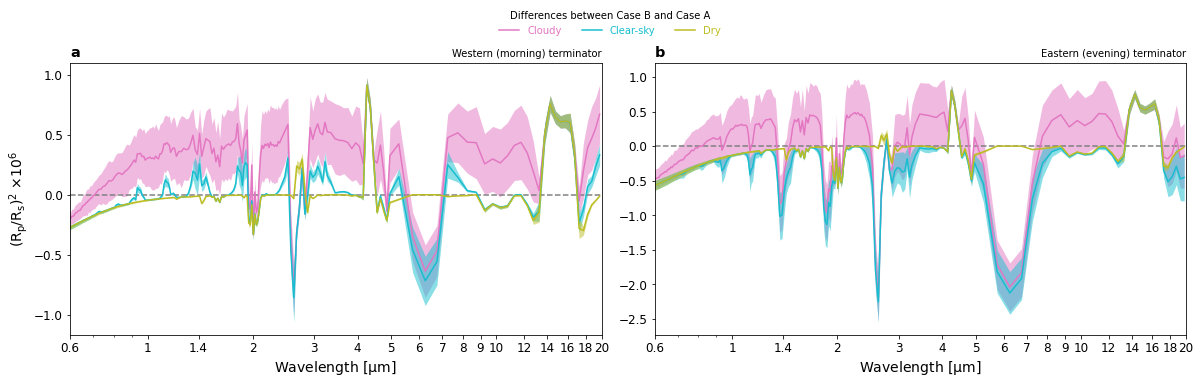

In [18]:
imgname = f"{img_prefix}__{sim_label_b}_minus_{sim_label_a}__{rad_opt_label}__{'_'.join(DIAGS.keys())}"
kw_plt_common = {}

fig = plt.figure(figsize=(20, 5))

axd = fig.subplot_mosaic([[*TERMINATORS.keys()]], gridspec_kw={"wspace": 0.1})

iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    ax.axhline(0, linestyle="--", color="tab:grey")
    xticks = np.concatenate([[0.6, 1, 1.4], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for term_key in TERMINATORS.keys():
    ax = axd[term_key]
    ax.set_title(
        TERMINATORS[term_key]["title"],
        loc="right",
        size="medium",
    )

    for vrbl_key, vrbl_prop in DIAGS.items():
        cube_mean = time_mean(TERM_DIFF[vrbl_key][term_key])
        cube_std = (TERM_DIFF[vrbl_key][term_key]).collapsed(
            um.t, iris.analysis.STD_DEV
        )
        x = cube_mean.coord("spectral_band_centres")
        ax.fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            linewidth=0,
            **vrbl_prop["kw_plt"],
        )
        ax.plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **vrbl_prop["kw_plt"],
        )

add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in DIAGS.values()},
    },
    loc="upper center",
    frameon=False,
    ncol=len(DIAGS),
    fontsize="medium",
    title="Differences between Case B and Case A",
    bbox_to_anchor=(0.5, 1.05),
)